In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, log_loss
from sklearn.model_selection import learning_curve

C:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Requirements

In [2]:
import importlib.metadata
def get_all_packages():
    """Get all installed package versions"""
    packages = {}
    for dist in importlib.metadata.distributions():
        name = dist.metadata['Name']
        version = dist.version
        packages[name.lower()] = version

    return packages

packages = get_all_packages()

# print("=" * 60)
# print(f"The number of packages: {len(packages)} ")
# print("=" * 60)
# for name, version in sorted(packages.items()):
#     print(f"{name:30} {version}")

# Export to requirements.txt file
with open(r'C:\Users\Administrator\Desktop\notebooks\requirements.txt', 'w', encoding='utf-8') as f:
    for name, version in sorted(packages.items()):
        f.write(f"{name:30} {version}\n")

## Import data

In [3]:
dataset = pd.read_excel(r'C:\Users\Administrator\Desktop\notebooks\data_with_all_Indicators_20230423.xls',sheet_name = 0)

features=['moveveh',  'rearend', 'sidewipe', 'district',   'struck', 'truck',  'private',    'newenergy', 'backveh',       'overspdload',
          'ageyoung', 'agemid',  'learner',  'experienced','edumid'	,'eduhigh','staff',      'worker' ,   'fullyfault',    'partlyfault',
          'beltuse',  'alcohol', 'dark' ,    'lowvisib',   'wet',    'rainy',  'unprotected','notrcnt',   'nointersection','freeway',
          'nocurve',  'peakam',  'peakpm',   'dweek1',     'dweek2', 'dweek3', 'dweek4',     'dweek5',    'dweek6',        'dmonth1',  'dmonth2',
          'dmonth3',  'dmonth4', 'dmonth5',  'dmonth6',    'dmonth7','dmonth8','dyear1',     'dyear2',    'dmonth9',       'dmonth10', 'dmonth11']

X = dataset[features]
y = dataset['injure']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 108)

print(f"Size of x_train: {X_train.shape}")
print(f"Size of x_test : {X_test.shape}")

Size of x_train: (2113, 52)
Size of x_test : (529, 52)


## Functions

In [4]:
# using final model to predict
def adjust_threshold(y_true, y_proba, model=None, plot=True):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_proba)
    f1_scores = 2 * precisions * recalls / (precisions + recalls + 1e-8)

    # Recall reaches target value and maximize Precision
    target_recall = 0.7
    valid_idx = np.where(recalls >= target_recall)[0]
    if len(valid_idx) > 0:
        best_idx = valid_idx[np.argmax(precisions[valid_idx])]
    else:
        best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]

    # Visualize threshold selection process
    if plot and model is not None:
        plt.figure(figsize=(8, 6))
        plt.plot(thresholds, recalls[:-1], label='Recall', color='red', linewidth=2)
        plt.plot(thresholds, precisions[:-1], label='Precision', color='blue', linewidth=2)
        plt.plot(thresholds, f1_scores[:-1], label='F1', color='green', linewidth=2)

        # Mark best threshold line
        plt.axvline(best_threshold, color='black', linestyle='--',
                   label=f'Best Threshold = {best_threshold:.3f}')

        # Mark best threshold point
        best_idx_thr = np.argmin(np.abs(thresholds - best_threshold))
        plt.scatter(best_threshold, recalls[best_idx_thr], color='red', s=100, zorder=5)
        plt.scatter(best_threshold, precisions[best_idx_thr], color='blue', s=100, zorder=5)
        plt.scatter(best_threshold, f1_scores[best_idx_thr], color='green', s=100, zorder=5)

        plt.xlabel('Threshold', fontsize=12)
        plt.ylabel('Score', fontsize=12)
        plt.title(f'{model.upper()} - Precision/Recall/F1 vs Threshold\n'
                 f'Best F1: {f1_scores[best_idx]:.3f}, '
                 f'Recall: {recalls[best_idx]:.3f}, '
                 f'Precision: {precisions[best_idx]:.3f}',
                 fontsize=13)
        plt.legend(fontsize=11)
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    # Return best threshold and corresponding metrics
    return {
        'threshold': best_threshold,
        'precision': precisions[best_idx],
        'recall': recalls[best_idx],
        'f1': f1_scores[best_idx]
    }

In [5]:
def predict(final_model, model_name, X_train, X_test, y_train, y_test):
    metrics_results=[]

    train_prob =final_model.predict_proba(X_train)[:, 1]
    test_prob = final_model.predict_proba(X_test)[:, 1]

    # adjust the threshold
    best_thr_info = adjust_threshold(y_train, train_prob, model=model_name)

    # Make predictions using optimal threshold
    train_pred = (train_prob >= best_thr_info['threshold']).astype(int)
    test_pred = (test_prob>= best_thr_info['threshold']).astype(int)

    print(f"adjust threshold is applied")

    train_accuracy = accuracy_score(y_train, train_pred)
    train_precision = precision_score(y_train, train_pred)
    train_recall = recall_score(y_train, train_pred)
    train_f1 = f1_score(y_train, train_pred)

    train_auc = roc_auc_score(y_train, train_prob)
    train_pr_auc = average_precision_score(y_train, train_prob)  # New PR-AUC

    # Test set metrics
    test_accuracy = accuracy_score(y_test, test_pred)
    test_precision = precision_score(y_test, test_pred)
    test_recall = recall_score(y_test, test_pred)
    test_f1 = f1_score(y_test, test_pred)

    test_auc = roc_auc_score(y_test, test_prob)
    test_pr_auc = average_precision_score(y_test, test_prob)  # New PR-AUC

    metrics_results.append({
        'Train_Accuracy': train_accuracy,
        'Train_Precision': train_precision,
        'Train_Recall': train_recall,
        'Train_F1': train_f1,
        'Train_AUC': train_auc,
        'Train_PR_AUC': train_pr_auc,
        'Test_Accuracy': test_accuracy,
        'Test_Precision': test_precision,
        'Test_Recall': test_recall,
        'Test_F1': test_f1,
        'Test_AUC': test_auc,
        'Test_PR_AUC': test_pr_auc
    })

    # DataFrame
    metrics_df = pd.DataFrame(metrics_results)

    print("=" * 95)
    # print(f"{'Model':<15} {'Dataset':<12} {'AUC-PR':<10} {'Recall':<10} {'F1-Score':<10} {'Precision':<10} {'AUC-ROC':<10} {'Accuracy':<10}")
    print(f"{'Model':<15}{'Dataset':<12} {'AUC-ROC':<10} {'Accuracy':<10} {'AUC-PR':<10} {'Recall':<10} {'F1-Score':<10} {'Precision':<10}")
    print("-" * 95)

    row = metrics_df.iloc[0]

    # Training set row
    print(f"{model_name:<15} {'Train':<12} {row['Train_AUC']:<10.4f} {row['Train_Accuracy']:<10.4f} {row['Train_PR_AUC']:<10.4f} {row['Train_Recall']:<10.4f} "
          f"{row['Train_F1']:<10.4f} {row['Train_Precision']:<10.4f}")

    # Test set row
    print(f"{'':<15} {'Test':<12} {row['Test_AUC']:<10.4f} {row['Test_Accuracy']:<10.4f} {row['Test_PR_AUC']:<10.4f} {row['Test_Recall']:<10.4f} "
          f"{row['Test_F1']:<10.4f} {row['Test_Precision']:<10.4f}")

    # Difference row
    diff_pr_auc = row['Train_PR_AUC'] - row['Test_PR_AUC']
    diff_recall = row['Train_Recall'] - row['Test_Recall']
    diff_f1 = row['Train_F1'] - row['Test_F1']
    diff_precision = row['Train_Precision'] - row['Test_Precision']
    diff_auc = row['Train_AUC'] - row['Test_AUC']
    diff_accuracy = row['Train_Accuracy'] - row['Test_Accuracy']

    print(f"{'':<15} {'Diff':<12} {diff_auc:<10.4f} {diff_accuracy:<10.4f} {diff_pr_auc:<10.4f} {diff_recall:<10.4f} "
          f"{diff_f1:<10.4f} {diff_precision:<10.4f} ")

    print("=" * 95)
    return metrics_results

In [6]:
def stability_analysis_and_visualization(model_name, detailed_df, feature_importance_df, top_k=25, save_fig=False):
    # Set matplotlib font settings
    plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
    plt.rcParams['axes.unicode_minus'] = False

    # Group by repeat and calculate mean and standard deviation for each metric
    repeat_stats_list = []

    for repeat in sorted(detailed_df['repeat'].unique()):
        repeat_data = detailed_df[detailed_df['repeat'] == repeat]

        repeat_stats = {'Repeat': repeat}
        for metric in ['accuracy', 'precision', 'recall', 'f1', 'auc', 'pr_auc']:
            mean_val = repeat_data[metric].mean()
            std_val = repeat_data[metric].std()
            repeat_stats[f'{metric}_mean'] = mean_val
            repeat_stats[f'{metric}_std'] = std_val

        repeat_stats_list.append(repeat_stats)

    repeat_stats_df = pd.DataFrame(repeat_stats_list)

    # Print statistics for each repeat
    metrics_display = ['auc','accuracy', 'precision', 'recall', 'f1',  'pr_auc']
    metric_names = ['AUC-ROC','Accuracy', 'Precision', 'Recall', 'F1',  'AUC-PR']

    # Calculate overall statistics for each metric
    overall_stats = []

    for metric, metric_name in zip(metrics_display, metric_names):
        # Mean of 5-fold averages across all repeats
        mean_of_means = repeat_stats_df[f'{metric}_mean'].mean()

        # Standard deviation of 5-fold averages (variability between repeats)
        std_of_means = repeat_stats_df[f'{metric}_mean'].std()

        # Mean of 5-fold standard deviations (variability within repeats)
        mean_of_stds = repeat_stats_df[f'{metric}_std'].mean()

        overall_stats.append({
            'Metric': metric_name,
            'Mean_of_Means': mean_of_means,
            'Std_of_Means': std_of_means,
            'Mean_of_Stds': mean_of_stds
        })

    overall_stats_df = pd.DataFrame(overall_stats)

    print(f"\noverall statistics across all repeats:")
    print("-" * 90)
    # Prepare data
    means = overall_stats_df['Mean_of_Means'].tolist()
    stds = overall_stats_df['Std_of_Means'].tolist()


    for name in metric_names:
        print(f"{name:<15}", end="")
    print()


    for mean, std in zip(means, stds):
        print(f"{mean:.4f}±{std:.4f}  ", end="")
    print()

    # Feature importance stability analysis - modified Jaccard calculation method
    print(f"\nfeature importance stability analysis:")
    print("-" * 90)

    # Store Jaccard similarity for each random seed
    jaccard_by_repeat = {}

    # For each random seed
    for repeat in sorted(feature_importance_df['repeat'].unique()):
        # Get all feature importance results for this random seed
        repeat_data = feature_importance_df[feature_importance_df['repeat'] == repeat]

        # Get top feature lists for 5 folds in this random seed
        fold_features = repeat_data['top_features'].tolist()

        # Calculate pairwise Jaccard similarity among 5 folds within this random seed
        jaccard_scores = []
        n_folds = len(fold_features)

        for i in range(n_folds):
            for j in range(i + 1, n_folds):
                set1 = set(fold_features[i])
                set2 = set(fold_features[j])
                if len(set1.union(set2)) > 0:
                    jaccard = len(set1.intersection(set2)) / len(set1.union(set2))
                    jaccard_scores.append(jaccard)

        # Calculate average Jaccard similarity for this random seed
        if jaccard_scores:
            jaccard_by_repeat[repeat] = np.mean(jaccard_scores)

    # Calculate mean and standard deviation of Jaccard similarity across 10 repeats
    if jaccard_by_repeat:
        jaccard_values = list(jaccard_by_repeat.values())
        jaccard_mean = np.mean(jaccard_values)
        jaccard_std = np.std(jaccard_values)
        print(f"Jaccard Similarity (Top-{top_k} features): {jaccard_mean:.4f} ± {jaccard_std:.4f}")
    else:
        print("Not enough data to calculate Jaccard similarity")

## XGBoost

In [7]:
xgb_param_grid = {
    # 'n_estimators':np.arange(500, 1400, 50),
    # 'max_depth': np.arange(2, 10, 1),
    # 'learning_rate': np.arange(0.01, 0.30, 0.01),
    # 'subsample': np.arange(0.4, 1.01, 0.3),
    # 'reg_alpha': np.arange(2, 11, 3),
    # 'reg_lambda': np.arange(2, 11, 3),
    # 'scale_pos_weight': np.arange(7, 19, 3),
    # 'colsample_bytree': np.arange(0.6, 1.01, 0.3),
    # 'min_child_weight': np.arange(2, 11, 4),
    # 'gamma': np.arange(0, 5, 1)

    'n_estimators':np.arange(1190, 1300, 10),
    'max_depth': np.arange(7, 8, 1),
    'learning_rate': np.arange(0.03, 0.04, 0.1),
    'subsample': np.arange(0.75, 0.76, 0.1),
    'reg_alpha': np.arange(11, 12, 1),
    'reg_lambda': np.arange(7, 8, 1),
    'scale_pos_weight': np.arange(10, 11, 1),
    'colsample_bytree': np.arange(0.75,0.76, 0.1),
    'min_child_weight': np.arange(10, 11, 1),
    'gamma': np.arange(3.22, 3.23, 0.01)
}

# Create XGBoost classifier
xgb_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric='aucpr',
    random_state=42,
    n_jobs=-1
)

# Configure GridSearchCV
xgb_grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_param_grid,
    scoring='average_precision',
    cv=5,
    verbose=1,
    n_jobs=-1,
    return_train_score=False
)

# Execute grid search
print("Starting XGBoost grid search...")
xgb_grid_search.fit(X_train, y_train, verbose=False)

# best parameters and best score
xgb_best_params = xgb_grid_search.best_params_
xgb_best_score = xgb_grid_search.best_score_

print(f"XGBoost grid search completed, best average precision: {xgb_best_score:.4f}")

# Print optimal parameters
print("\nXGBoost Optimal Parameters:")
print("-" * 40)
xgb_max_param_length = max(len(param) for param in xgb_best_params.keys())
for param, value in xgb_best_params.items():
    if isinstance(value, (int, np.integer)):
        xgb_formatted_value = f"{value:>8d}"
    elif isinstance(value, float):
        xgb_formatted_value = f"{value:>8.6f}"
    elif value is None:
        xgb_formatted_value = f"{'None':>8}"
    else:
        xgb_formatted_value = f"{str(value):>8}"
    print(f"  {param:<{xgb_max_param_length}} : {xgb_formatted_value}")


Starting XGBoost grid search...
Fitting 5 folds for each of 11 candidates, totalling 55 fits
XGBoost grid search completed, best average precision: 0.4044

XGBoost Optimal Parameters:
----------------------------------------
  colsample_bytree : 0.750000
  gamma            : 3.220000
  learning_rate    : 0.030000
  max_depth        :        7
  min_child_weight :       10
  n_estimators     :     1290
  reg_alpha        :       11
  reg_lambda       :        7
  scale_pos_weight :       10
  subsample        : 0.750000


xgboost final training...
xgboost training completed...


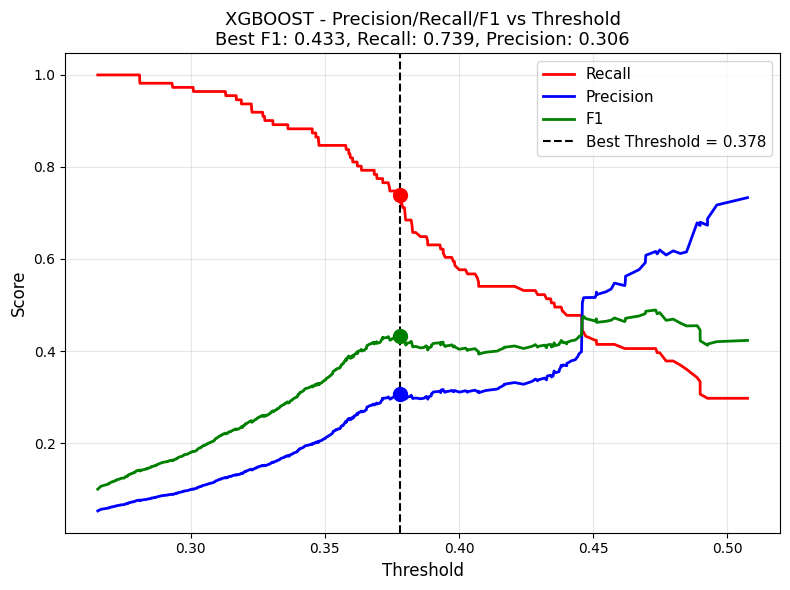

adjust threshold is applied
Model          Dataset      AUC-ROC    Accuracy   AUC-PR     Recall     F1-Score   Precision 
-----------------------------------------------------------------------------------------------
xgboost         Train        0.9109     0.8982     0.4556     0.7387     0.4327     0.3060    
                Test         0.8687     0.8922     0.4179     0.7500     0.4242     0.2958    
                Diff         0.0422     0.0060     0.0377     -0.0113    0.0085     0.0102     


In [8]:
print("xgboost final training...")

xgb_final_model = XGBClassifier(
    **xgb_best_params,
    # n_estimators=1000,
    objective="binary:logistic",
    eval_metric='aucpr',
    early_stopping_rounds=30,
    random_state=42
)

xgb_final_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=False)

print("xgboost training completed...")

xgb_metrics_results = predict(xgb_final_model,'xgboost', X_train, X_test, y_train, y_test)

In [9]:
# Stability
def stability_analysis_xgboost(params, x_tr, y_tr, n_splits=5, n_repeats=10, top_k=25):
    print(f"stability analysis: XGBoost...")

    # Store detailed cross-validation results
    detailed_results = {
        'repeat': [],
        'fold': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'auc': [],
        'pr_auc': []
    }

    # Store
    feature_importance_results = {
        'repeat': [],
        'fold': [],
        'top_features': []  # Store list of top k important features
    }

    # Get feature names
    feature_names = x_tr.columns if hasattr(x_tr, 'columns') else [f'feature_{i}' for i in range(x_tr.shape[1])]

    # Repeat cross-validation multiple times to evaluate stability
    for repeat_idx in range(n_repeats):
        # Use stratified K-fold cross-validation
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=repeat_idx)

        fold_idx = 0
        for train_idx, test_idx in skf.split(x_tr, y_tr):
            x_train, x_test = x_tr.iloc[train_idx], x_tr.iloc[test_idx]
            y_train, y_test = y_tr.iloc[train_idx], y_tr.iloc[test_idx]

            model_train = XGBClassifier(
                **params,
                objective="binary:logistic",
                eval_metric='aucpr',
                random_state=42)

            model_train.fit(x_train,y_train,
                            verbose=False)

            # Predict
            y_pred = model_train.predict(x_test)
            y_pred_proba = model_train.predict_proba(x_test)[:, 1]

            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            auc = roc_auc_score(y_test, y_pred_proba)
            pr_auc = average_precision_score(y_test, y_pred_proba)

            # Store detailed results
            detailed_results['repeat'].append(repeat_idx)
            detailed_results['fold'].append(fold_idx)
            detailed_results['accuracy'].append(accuracy)
            detailed_results['precision'].append(precision)
            detailed_results['recall'].append(recall)
            detailed_results['f1'].append(f1)
            detailed_results['auc'].append(auc)
            detailed_results['pr_auc'].append(pr_auc)

            # Get feature importance for XGBoost
            importance_dict = model_train.get_booster().get_score(importance_type='total_gain')
            feature_importance = np.array([importance_dict.get(f, 0) for f in feature_names])

            # Create feature importance DataFrame and sort by importance
            feature_df = pd.DataFrame({
                'feature': feature_names,
                'importance': feature_importance
            }).sort_values('importance', ascending=False)

            # Store top k important features
            top_features = feature_df['feature'].head(top_k).tolist()

            feature_importance_results['repeat'].append(repeat_idx)
            feature_importance_results['fold'].append(fold_idx)
            feature_importance_results['top_features'].append(top_features)

            fold_idx += 1

    # Convert detailed results to DataFrame
    detailed_df = pd.DataFrame(detailed_results)
    feature_importance_df = pd.DataFrame(feature_importance_results)

    return detailed_df, feature_importance_df

xgboost_detailed, xgboost_features = stability_analysis_xgboost(xgb_best_params, X_train, y_train,n_splits=5, n_repeats=10, top_k=25)

overall_stats = stability_analysis_and_visualization('xgboost', xgboost_detailed, xgboost_features, 25, False)


stability analysis: XGBoost...

overall statistics across all repeats:
------------------------------------------------------------------------------------------
AUC-ROC        Accuracy       Precision      Recall         F1             AUC-PR         
0.8710±0.0064  0.8866±0.0031  0.2474±0.0083  0.5619±0.0193  0.3423±0.0102  0.3959±0.0107  

feature importance stability analysis:
------------------------------------------------------------------------------------------
Jaccard Similarity (Top-25 features): 0.7231 ± 0.0222


## Catboost

In [10]:
cb_param_grid = {
    # 'iterations': np.arange(20, 41, 1),
    # 'depth':np.arange(1, 5, 1),
    # 'learning_rate':np.arange(0.007,0.013,0.001),
    # 'l2_leaf_reg': np.arange(2, 5, 1),

    'iterations': np.arange(32, 36, 1),
    'depth':np.arange(3, 4, 1),
    'learning_rate':np.arange(0.009,0.010,0.01),
    'l2_leaf_reg': np.arange(3, 4, 1),
    'subsample':np.arange(0.8, 0.9, 0.1),
    'border_count': [64, 128],
}

# Create XGBoost classifier
cb_model = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='PRAUC',
    auto_class_weights='SqrtBalanced',
    random_state=42,
    logging_level='Silent',
)

# Configure GridSearchCV
cb_grid_search = GridSearchCV(
    estimator=cb_model,
    param_grid=cb_param_grid,
    scoring='average_precision',
    cv=5,
    verbose=1,
    n_jobs=-1,
    return_train_score=False
)

# Execute grid search
print("Starting CatBoost grid search...")
cb_grid_search.fit(X_train, y_train, verbose=False)

# best parameters and best score
cb_best_params = cb_grid_search.best_params_
cb_best_score = cb_grid_search.best_score_

print(f"CatBoost grid search completed, best average precision: {cb_best_score:.4f}")

# Print optimal parameters
print("\nCatBoost Optimal Parameters:")
print("-" * 40)
cb_max_param_length = max(len(param) for param in cb_best_params.keys())
for param, value in cb_best_params.items():
    if isinstance(value, (int, np.integer)):
        cb_formatted_value = f"{value:>8d}"
    elif isinstance(value, float):
        cb_formatted_value = f"{value:>8.6f}"
    elif value is None:
        cb_formatted_value = f"{'None':>8}"
    else:
        cb_formatted_value = f"{str(value):>8}"
    print(f"  {param:<{cb_max_param_length}} : {cb_formatted_value}")

Starting CatBoost grid search...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
CatBoost grid search completed, best average precision: 0.4018

CatBoost Optimal Parameters:
----------------------------------------
  border_count  :       64
  depth         :        3
  iterations    :       33
  l2_leaf_reg   :        3
  learning_rate : 0.009000
  subsample     : 0.800000


In [11]:
print("Catboost training...")
cb_final_model = CatBoostClassifier(
    **cb_best_params,
    loss_function='Logloss',
    eval_metric='PRAUC',
    auto_class_weights='SqrtBalanced',
    random_state=42,
    logging_level='Silent'
    )

cb_final_model.fit(
    X_train, y_train,
    verbose=False
    )

print("Catboost training completed...")

cb_metrics_results = predict(cb_final_model,'catboost', X_train, X_test, y_train, y_test)

Catboost training...
Catboost training completed...


adjust threshold is applied
Model          Dataset      AUC-ROC    Accuracy   AUC-PR     Recall     F1-Score   Precision 
-----------------------------------------------------------------------------------------------
catboost        Train        0.8956     0.8500     0.4371     0.7027     0.3298     0.2155    
                Test         0.8682     0.8412     0.3980     0.7500     0.3333     0.2143    
                Diff         0.0274     0.0088     0.0391     -0.0473    -0.0035    0.0012     


In [12]:
# Stability test
def stability_analysis_catboost(params, x_tr, y_tr, n_splits=5, n_repeats=10, top_k=25):
    print(f"stability analysis: CatBoost...")

    # Store detailed cross-validation results
    detailed_results = {
        'repeat': [],
        'fold': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'auc': [],
        'pr_auc': []
    }

    # Store
    feature_importance_results = {
        'repeat': [],
        'fold': [],
        'top_features': []  # Store list of top k important features
    }

    # Get feature names
    feature_names = x_tr.columns if hasattr(x_tr, 'columns') else [f'feature_{i}' for i in range(x_tr.shape[1])]

    # Repeat cross-validation multiple times to evaluate stability
    for repeat_idx in range(n_repeats):
        # Use stratified K-fold cross-validation
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=repeat_idx)

        fold_idx = 0
        for train_idx, test_idx in skf.split(x_tr, y_tr):
            x_train, x_test = x_tr.iloc[train_idx], x_tr.iloc[test_idx]
            y_train, y_test = y_tr.iloc[train_idx], y_tr.iloc[test_idx]

            # Create and train CatBoost model
            model_train = CatBoostClassifier(**params, loss_function='Logloss', eval_metric='PRAUC',
                                           auto_class_weights='SqrtBalanced', random_state=42, logging_level='Silent')
            model_train.fit(x_train, y_train)

            # Predict
            y_pred = model_train.predict(x_test)
            y_pred_proba = model_train.predict_proba(x_test)[:, 1]

            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            auc = roc_auc_score(y_test, y_pred_proba)
            pr_auc = average_precision_score(y_test, y_pred_proba)

            # Store detailed results
            detailed_results['repeat'].append(repeat_idx)
            detailed_results['fold'].append(fold_idx)
            detailed_results['accuracy'].append(accuracy)
            detailed_results['precision'].append(precision)
            detailed_results['recall'].append(recall)
            detailed_results['f1'].append(f1)
            detailed_results['auc'].append(auc)
            detailed_results['pr_auc'].append(pr_auc)

            # Get feature importance for CatBoost
            feature_importance = model_train.get_feature_importance()

            # Create feature importance DataFrame and sort by importance
            feature_df = pd.DataFrame({
                'feature': feature_names,
                'importance': feature_importance
            }).sort_values('importance', ascending=False)

            # Store top k important features
            top_features = feature_df['feature'].head(top_k).tolist()

            feature_importance_results['repeat'].append(repeat_idx)
            feature_importance_results['fold'].append(fold_idx)
            feature_importance_results['top_features'].append(top_features)

            fold_idx += 1

    # Convert detailed results to DataFrame
    detailed_df = pd.DataFrame(detailed_results)
    feature_importance_df = pd.DataFrame(feature_importance_results)
    return detailed_df, feature_importance_df

catboost_detailed, catboost_features = stability_analysis_catboost(cb_best_params, X_train, y_train,n_splits=5, n_repeats=10, top_k=25)

stability_analysis_and_visualization('catboost', catboost_detailed, catboost_features,25)



stability analysis: CatBoost...

overall statistics across all repeats:
------------------------------------------------------------------------------------------
AUC-ROC        Accuracy       Precision      Recall         F1             AUC-PR         
0.8609±0.0061  0.9146±0.0020  0.3120±0.0082  0.4830±0.0254  0.3757±0.0105  0.3947±0.0158  

feature importance stability analysis:
------------------------------------------------------------------------------------------
Jaccard Similarity (Top-25 features): 0.5339 ± 0.0337


## Random forest

In [13]:
# Define parameter grid for Random Forest using range and step size
rf_param_grid = {
    # 'n_estimators': np.arange(50, 501, 50),  # 50 to 500, step size 50
    # 'max_depth': [None, 5, 10, 15, 20],  # None and specific values
    # 'min_samples_split': np.arange(2, 15, 2),  # 2 to 14, step size 2
    # 'min_samples_leaf': np.arange(1, 10, 2),  # 1 to 9, step size 2
    # 'max_features': ['sqrt', 'log2', None],  # categorical values
    # 'bootstrap': [True, False]  # categorical values

    'n_estimators': np.arange(1, 50, 1),
    'max_depth': np.arange(1, 5, 1),
    'min_samples_split': np.arange(2, 3, 1),
    'min_samples_leaf': np.arange(2, 5, 1),
    'max_features': ['sqrt'],
    'bootstrap': [True]
}

# Create Random Forest classifier
rf_model = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Configure GridSearchCV
rf_grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_param_grid,
    scoring='average_precision',
    cv=5,
    verbose=1,
    n_jobs=-1,
    return_train_score=False
)

# Execute grid search
print("Starting Random Forest grid search...")
rf_grid_search.fit(X_train, y_train)

# best parameters and best score
rf_best_params = rf_grid_search.best_params_
rf_best_score = rf_grid_search.best_score_

print(f"Random Forest grid search completed, best average precision: {rf_best_score:.4f}")

# Print optimal parameters
print("\nRandom Forest Optimal Parameters:")
print("-" * 40)
rf_max_param_length = max(len(param) for param in rf_best_params.keys())
for param, value in rf_best_params.items():
    if isinstance(value, (int, np.integer)):
        rf_formatted_value = f"{value:>8d}"
    elif isinstance(value, float):
        rf_formatted_value = f"{value:>8.6f}"
    elif value is None:
        rf_formatted_value = f"{'None':>8}"
    elif isinstance(value, str):
        rf_formatted_value = f"{value:>8}"
    elif isinstance(value, bool):
        rf_formatted_value = f"{str(value):>8}"
    else:
        rf_formatted_value = f"{str(value):>8}"
    print(f"  {param:<{rf_max_param_length}} : {rf_formatted_value}")


Starting Random Forest grid search...
Fitting 5 folds for each of 588 candidates, totalling 2940 fits
Random Forest grid search completed, best average precision: 0.3883

Random Forest Optimal Parameters:
----------------------------------------
  bootstrap         :        1
  max_depth         :        2
  max_features      :     sqrt
  min_samples_leaf  :        4
  min_samples_split :        2
  n_estimators      :       26


random_forest training...
random_forest training completed...


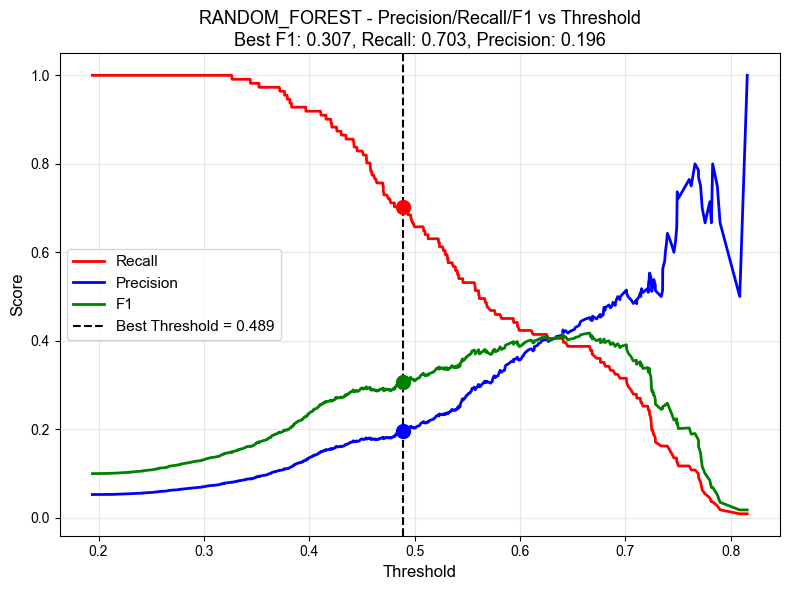

adjust threshold is applied
Model          Dataset      AUC-ROC    Accuracy   AUC-PR     Recall     F1-Score   Precision 
-----------------------------------------------------------------------------------------------
random_forest   Train        0.8837     0.8334     0.3669     0.7027     0.3071     0.1965    
                Test         0.8638     0.8110     0.3814     0.7500     0.2958     0.1842    
                Diff         0.0199     0.0224     -0.0145    -0.0473    0.0113     0.0123     


In [14]:
print("random_forest training...")

rf_final_model = RandomForestClassifier(
            **rf_best_params,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        )
rf_final_model.fit(X_train, y_train)

print("random_forest training completed...")

rf_metrics_results = predict(rf_final_model,'random_forest', X_train, X_test, y_train, y_test)


In [15]:
# Stability test
def stability_analysis_random_forest(params, x_tr, y_tr, n_splits=5, n_repeats=10, top_k=25):
    print(f"stability analysis: Random Forest...")

    # Store detailed cross-validation results
    detailed_results = {
        'repeat': [],
        'fold': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'auc': [],
        'pr_auc': []
    }

    # Store
    feature_importance_results = {
        'repeat': [],
        'fold': [],
        'top_features': []  # Store list of top k important features
    }

    # Get feature names
    feature_names = x_tr.columns if hasattr(x_tr, 'columns') else [f'feature_{i}' for i in range(x_tr.shape[1])]

    # Repeat cross-validation multiple times to evaluate stability
    for repeat_idx in range(n_repeats):
        # Use stratified K-fold cross-validation
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=repeat_idx)

        fold_idx = 0
        for train_idx, test_idx in skf.split(x_tr, y_tr):
            x_train, x_test = x_tr.iloc[train_idx], x_tr.iloc[test_idx]
            y_train, y_test = y_tr.iloc[train_idx], y_tr.iloc[test_idx]

            # Create and train Random Forest model
            model_train = RandomForestClassifier(**params, class_weight='balanced', random_state=42, n_jobs=-1)
            model_train.fit(x_train, y_train)

            # Predict
            y_pred = model_train.predict(x_test)
            y_pred_proba = model_train.predict_proba(x_test)[:, 1]

            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            auc = roc_auc_score(y_test, y_pred_proba)
            pr_auc = average_precision_score(y_test, y_pred_proba)

            # Store detailed results
            detailed_results['repeat'].append(repeat_idx)
            detailed_results['fold'].append(fold_idx)
            detailed_results['accuracy'].append(accuracy)
            detailed_results['precision'].append(precision)
            detailed_results['recall'].append(recall)
            detailed_results['f1'].append(f1)
            detailed_results['auc'].append(auc)
            detailed_results['pr_auc'].append(pr_auc)

            # Get feature importance for Random Forest
            feature_importance = model_train.feature_importances_

            # Create feature importance DataFrame and sort by importance
            feature_df = pd.DataFrame({
                'feature': feature_names,
                'importance': feature_importance
            }).sort_values('importance', ascending=False)

            # Store top k important features
            top_features = feature_df['feature'].head(top_k).tolist()

            feature_importance_results['repeat'].append(repeat_idx)
            feature_importance_results['fold'].append(fold_idx)
            feature_importance_results['top_features'].append(top_features)

            fold_idx += 1

    # Convert detailed results to DataFrame
    detailed_df = pd.DataFrame(detailed_results)
    feature_importance_df = pd.DataFrame(feature_importance_results)

    return detailed_df, feature_importance_df

random_forest_detailed, random_forest_features = stability_analysis_random_forest(rf_best_params, X_train, y_train,n_splits=5, n_repeats=10, top_k=25)
stability_analysis_and_visualization('random_forest', random_forest_detailed, random_forest_features,25)

stability analysis: Random Forest...

overall statistics across all repeats:
------------------------------------------------------------------------------------------
AUC-ROC        Accuracy       Precision      Recall         F1             AUC-PR         
0.8616±0.0025  0.8210±0.0046  0.1793±0.0051  0.6711±0.0209  0.2827±0.0072  0.3624±0.0111  

feature importance stability analysis:
------------------------------------------------------------------------------------------
Jaccard Similarity (Top-25 features): 0.5396 ± 0.0319


## Extra Trees

In [16]:
# Define parameter grid for Extra Trees using range and step size
et_param_grid = {
    'n_estimators': np.arange(9, 13, 1),
    'max_depth': [2,3,4,5,6],
    'min_samples_split': np.arange(2, 4, 1),
    'min_samples_leaf': np.arange(20, 25, 1),
    'max_features': ['sqrt'],
    'bootstrap': [True, False]
}

# Create Extra Trees classifier
et_model = ExtraTreesClassifier(
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Configure GridSearchCV
et_grid_search = GridSearchCV(
    estimator=et_model,
    param_grid=et_param_grid,
    scoring='average_precision',
    cv=5,
    verbose=1,
    n_jobs=-1,
    return_train_score=False
)

# Execute grid search
print("Starting Extra Trees grid search...")
et_grid_search.fit(X_train, y_train)

# best parameters and best score
et_best_params = et_grid_search.best_params_
et_best_score = et_grid_search.best_score_

print(f"Extra Trees grid search completed, best average precision: {et_best_score:.4f}")

# Print optimal parameters
print("\nExtra Trees Optimal Parameters:")
print("-" * 40)
et_max_param_length = max(len(param) for param in et_best_params.keys())
for param, value in et_best_params.items():
    if isinstance(value, (int, np.integer)):
        et_formatted_value = f"{value:>8d}"
    elif isinstance(value, float):
        et_formatted_value = f"{value:>8.6f}"
    elif value is None:
        et_formatted_value = f"{'None':>8}"
    elif isinstance(value, str):
        et_formatted_value = f"{value:>8}"
    elif isinstance(value, bool):
        et_formatted_value = f"{str(value):>8}"
    else:
        et_formatted_value = f"{str(value):>8}"
    print(f"  {param:<{et_max_param_length}} : {et_formatted_value}")

Starting Extra Trees grid search...
Fitting 5 folds for each of 400 candidates, totalling 2000 fits
Extra Trees grid search completed, best average precision: 0.4160

Extra Trees Optimal Parameters:
----------------------------------------
  bootstrap         :        1
  max_depth         :        6
  max_features      :     sqrt
  min_samples_leaf  :       22
  min_samples_split :        2
  n_estimators      :       12


extra_trees training...
extra_trees training completed...


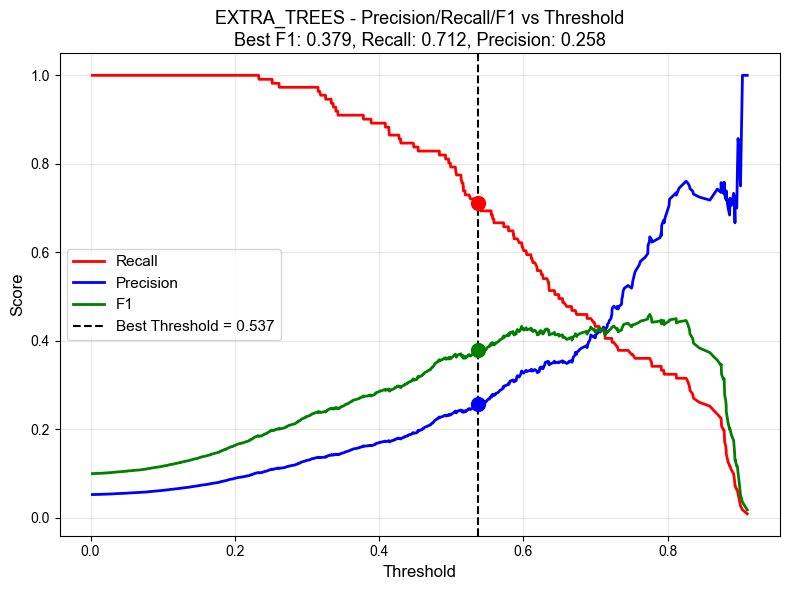

adjust threshold is applied
Model          Dataset      AUC-ROC    Accuracy   AUC-PR     Recall     F1-Score   Precision 
-----------------------------------------------------------------------------------------------
extra_trees     Train        0.9113     0.8774     0.4506     0.7117     0.3789     0.2582    
                Test         0.8643     0.8639     0.4255     0.6429     0.3333     0.2250    
                Diff         0.0469     0.0135     0.0250     0.0689     0.0456     0.0332     


In [17]:
print("extra_trees training...")

et_final_model = ExtraTreesClassifier(
    **et_best_params,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
    )
et_final_model.fit(X_train, y_train)

print("extra_trees training completed...")

et_metrics_results = predict(et_final_model,'extra_trees', X_train, X_test, y_train, y_test)

In [18]:
# Stability test
def stability_analysis_extra_trees(params, x_tr, y_tr, n_splits=5, n_repeats=10, top_k=25):
    print(f"stability analysis: Extra Trees...")

    # Store detailed cross-validation results
    detailed_results = {
        'repeat': [],
        'fold': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'auc': [],
        'pr_auc': []
    }

    # Store
    feature_importance_results = {
        'repeat': [],
        'fold': [],
        'top_features': []  # Store list of top k important features
    }

    # Get feature names
    feature_names = x_tr.columns if hasattr(x_tr, 'columns') else [f'feature_{i}' for i in range(x_tr.shape[1])]

    # Repeat cross-validation multiple times to evaluate stability
    for repeat_idx in range(n_repeats):
        # Use stratified K-fold cross-validation
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=repeat_idx)

        fold_idx = 0
        for train_idx, test_idx in skf.split(x_tr, y_tr):
            x_train, x_test = x_tr.iloc[train_idx], x_tr.iloc[test_idx]
            y_train, y_test = y_tr.iloc[train_idx], y_tr.iloc[test_idx]

            # Create and train Extra Trees model
            model_train = ExtraTreesClassifier(**params, class_weight='balanced', random_state=42, n_jobs=-1)
            model_train.fit(x_train, y_train)

            # Predict
            y_pred = model_train.predict(x_test)
            y_pred_proba = model_train.predict_proba(x_test)[:, 1]

            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            auc = roc_auc_score(y_test, y_pred_proba)
            pr_auc = average_precision_score(y_test, y_pred_proba)

            # Store detailed results
            detailed_results['repeat'].append(repeat_idx)
            detailed_results['fold'].append(fold_idx)
            detailed_results['accuracy'].append(accuracy)
            detailed_results['precision'].append(precision)
            detailed_results['recall'].append(recall)
            detailed_results['f1'].append(f1)
            detailed_results['auc'].append(auc)
            detailed_results['pr_auc'].append(pr_auc)

            # Get feature importance for Extra Trees
            feature_importance = model_train.feature_importances_

            # Create feature importance DataFrame and sort by importance
            feature_df = pd.DataFrame({
                'feature': feature_names,
                'importance': feature_importance
            }).sort_values('importance', ascending=False)

            # Store top k important features
            top_features = feature_df['feature'].head(top_k).tolist()

            feature_importance_results['repeat'].append(repeat_idx)
            feature_importance_results['fold'].append(fold_idx)
            feature_importance_results['top_features'].append(top_features)

            fold_idx += 1

    # Convert detailed results to DataFrame
    detailed_df = pd.DataFrame(detailed_results)
    feature_importance_df = pd.DataFrame(feature_importance_results)

    return detailed_df, feature_importance_df

extra_trees_detailed, extra_trees_features = stability_analysis_extra_trees(et_best_params, X_train, y_train,n_splits=5, n_repeats=10, top_k=25)
stability_analysis_and_visualization('extra_trees', extra_trees_detailed, extra_trees_features,25)


stability analysis: Extra Trees...

overall statistics across all repeats:
------------------------------------------------------------------------------------------
AUC-ROC        Accuracy       Precision      Recall         F1             AUC-PR         
0.8619±0.0083  0.8422±0.0069  0.2035±0.0098  0.6720±0.0124  0.3113±0.0116  0.3712±0.0284  

feature importance stability analysis:
------------------------------------------------------------------------------------------
Jaccard Similarity (Top-25 features): 0.5626 ± 0.0291


## Comparison

In [19]:
# Results in metrics for final model
models = {
    'XGBoost': xgb_metrics_results[0],
    'CatBoost': cb_metrics_results[0],
    'Random Forest': rf_metrics_results[0],
    'Extra Trees': et_metrics_results[0]
}

def print_results_in_metrics_for_final_model(models):
    print("Model Performance Comparison Table")
    print("=" * 95)
    # Print header
    print(f"{'Model':<15} {'Dataset':<12} {'AUC-ROC':<10} {'Accuracy':<10} {'AUC-PR':<10} {'Recall':<10} {'F1-Score':<10} {'Precision':<10} ")
    print("-" * 95)

    # Loop through each model
    for model_name, metrics in models.items():
        # Training set row
        print(f"{model_name:<15} {'Train':<12} {metrics['Train_AUC']:<10.4f} {metrics['Train_Accuracy']:<10.4f} {metrics['Train_PR_AUC']:<10.4f} {metrics['Train_Recall']:<10.4f} "
              f"{metrics['Train_F1']:<10.4f} {metrics['Train_Precision']:<10.4f} ")

        # Test set row
        print(f"{'':<15} {'Test':<12} {metrics['Test_AUC']:<10.4f} {metrics['Test_Accuracy']:<10.4f} {metrics['Test_PR_AUC']:<10.4f} {metrics['Test_Recall']:<10.4f} "
              f"{metrics['Test_F1']:<10.4f} {metrics['Test_Precision']:<10.4f} ")

        # Difference row
        diff_pr_auc = metrics['Train_PR_AUC'] - metrics['Test_PR_AUC']
        diff_recall = metrics['Train_Recall'] - metrics['Test_Recall']
        diff_f1 = metrics['Train_F1'] - metrics['Test_F1']
        diff_precision = metrics['Train_Precision'] - metrics['Test_Precision']
        diff_auc = metrics['Train_AUC'] - metrics['Test_AUC']
        diff_accuracy = metrics['Train_Accuracy'] - metrics['Test_Accuracy']

        print(f"{'':<15} {'Diff':<12} {diff_auc:<10.4f} {diff_accuracy:<10.4f} {diff_pr_auc:<10.4f} {diff_recall:<10.4f} "
              f"{diff_f1:<10.4f} {diff_precision:<10.4f} ")

        # Print separator between models
        # print()
    print("=" * 95)

print_results_in_metrics_for_final_model(models)

Model Performance Comparison Table
Model           Dataset      AUC-ROC    Accuracy   AUC-PR     Recall     F1-Score   Precision  
-----------------------------------------------------------------------------------------------
XGBoost         Train        0.9109     0.8982     0.4556     0.7387     0.4327     0.3060     
                Test         0.8687     0.8922     0.4179     0.7500     0.4242     0.2958     
                Diff         0.0422     0.0060     0.0377     -0.0113    0.0085     0.0102     
CatBoost        Train        0.8956     0.8500     0.4371     0.7027     0.3298     0.2155     
                Test         0.8682     0.8412     0.3980     0.7500     0.3333     0.2143     
                Diff         0.0274     0.0088     0.0391     -0.0473    -0.0035    0.0012     
Random Forest   Train        0.8837     0.8334     0.3669     0.7027     0.3071     0.1965     
                Test         0.8638     0.8110     0.3814     0.7500     0.2958     0.1842     
     

In [20]:
def stability_analysis_and_visualization_comparison(detailed_results_all_, feature_importance_results_all_, top_k=20):

    # Set matplotlib font settings
    plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
    plt.rcParams['axes.unicode_minus'] = False

    # Define metrics and display names
    metrics_display = ['pr_auc', 'recall', 'precision', 'f1', 'accuracy', 'auc']
    metric_names = ['AUC-PR', 'Accuracy', 'AUC-ROC', 'Recall', 'Precision', 'F1']

    # Store overall statistical results for each model
    model_overall_stats = {}
    model_names = list(detailed_results_all_.keys())

    # Define color scheme and marker symbols
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    markers = ['o', 's', '^', 'D']  # circle, square, triangle, diamond

    # Create subplot for each metric
    for idx, (metric, metric_name) in enumerate(zip(metrics_display, metric_names)):
        for model_idx, model_name_ in enumerate(model_names):
            detailed_df_ = detailed_results_all_[model_name_]
            # Calculate 5-fold average and standard deviation for each repeat
            repeat_means = []
            repeat_stds = []
            repeat_indices = []

            for repeat in sorted(detailed_df_['repeat'].unique()):
                repeat_data = detailed_df_[detailed_df_['repeat'] == repeat]
                repeat_mean = repeat_data[metric].mean()
                repeat_std = repeat_data[metric].std()
                repeat_means.append(repeat_mean)
                repeat_stds.append(repeat_std)
                repeat_indices.append(repeat)

            # Store overall statistics for the model
            if model_name_ not in model_overall_stats:
                model_overall_stats[model_name_] = {}

            model_overall_stats[model_name_][f'{metric}_mean'] = np.mean(repeat_means)
            model_overall_stats[model_name_][f'{metric}_std'] = np.std(repeat_means)

    # Output performance stability comparison table
    print("\nPerformance Stability Comparison Across All Models")
    print("=" * 110)

    # Table header
    header_format = "{:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15}"
    print(header_format.format("Model", "AUC-PR", "Recall", "Precision", "F1", "Accuracy", "AUC-ROC"))
    print("-" * 110)

    # Find best value for each metric (highest mean)
    best_values = {}
    for metric in metrics_display:
        best_mean = -1
        best_model = None
        for model_name_ in model_names:
            mean_val = model_overall_stats[model_name_][f'{metric}_mean']
            if mean_val > best_mean:
                best_mean = mean_val
                best_model = model_name_
        best_values[metric] = best_model

    # Output data row for each model
    for model_name_ in model_names:
        row_data = [model_name_]

        for metric in metrics_display:
            mean_val = model_overall_stats[model_name_][f'{metric}_mean']
            std_val = model_overall_stats[model_name_][f'{metric}_std']

            # Mark best value
            if best_values[metric] == model_name_:
                formatted = f"{mean_val:.3f} ± {std_val:.3f}*"
            else:
                formatted = f"{mean_val:.3f} ± {std_val:.3f}"

            row_data.append(formatted)

        print(header_format.format(*row_data))

    print("=" * 110)

    # Feature importance stability analysis (Jaccard similarity) - modified calculation method
    print("\n\nFeature Importance Stability Comparison (Jaccard Similarity)")
    print("=" * 60)

    # Table header
    jaccard_header = "{:<20} {:<15} {:<15}"
    print(jaccard_header.format("Model", "Mean", "Std"))
    print("-" * 60)

    # Store Jaccard similarity results for each model (by random seed)
    jaccard_by_repeat_all_models = {}

    # Calculate Jaccard similarity for each model
    for model_name_ in model_names:
        feature_importance_df = feature_importance_results_all_[model_name_]

        # Store Jaccard similarity for each random seed
        jaccard_by_repeat = {}

        # For each random seed
        for repeat in sorted(feature_importance_df['repeat'].unique()):
            # Get all feature importance results for this random seed
            repeat_data = feature_importance_df[feature_importance_df['repeat'] == repeat]

            # Get top feature lists for 5 folds in this random seed
            fold_features = repeat_data['top_features'].tolist()

            # Calculate pairwise Jaccard similarity among 5 folds within this random seed
            jaccard_scores = []
            n_folds = len(fold_features)

            for i in range(n_folds):
                for j in range(i + 1, n_folds):
                    set1 = set(fold_features[i])
                    set2 = set(fold_features[j])
                    if len(set1.union(set2)) > 0:
                        jaccard = len(set1.intersection(set2)) / len(set1.union(set2))
                        jaccard_scores.append(jaccard)

            # Calculate average Jaccard similarity for this random seed
            if jaccard_scores:
                jaccard_by_repeat[repeat] = np.mean(jaccard_scores)

        # Store Jaccard similarity results for this model
        jaccard_by_repeat_all_models[model_name_] = jaccard_by_repeat

    # Find best Jaccard similarity value (highest mean)
    best_jaccard_mean = -1
    best_jaccard_model = None

    # Output Jaccard similarity results
    for model_name_ in model_names:
        jaccard_by_repeat = jaccard_by_repeat_all_models[model_name_]

        if jaccard_by_repeat:
            # Extract Jaccard similarity for all random seeds
            jaccard_values = list(jaccard_by_repeat.values())
            jaccard_mean = np.mean(jaccard_values)
            jaccard_std = np.std(jaccard_values)

            # Mark best value
            if jaccard_mean > best_jaccard_mean:
                best_jaccard_mean = jaccard_mean
                best_jaccard_model = model_name_

            # Output in table
            if model_name_ == best_jaccard_model:
                mean_str = f"{jaccard_mean:.4f}*"
            else:
                mean_str = f"{jaccard_mean:.4f}"

            print(jaccard_header.format(model_name_, mean_str, f"{jaccard_std:.4f}"))

    print("=" * 60)

detailed_results_all = {
    'xgboost': xgboost_detailed,
    'catboost': catboost_detailed,
    'random_forest': random_forest_detailed,
    'extra_trees': extra_trees_detailed
}

feature_importance_results_all = {
    'xgboost': xgboost_features,
    'catboost': catboost_features,
    'random_forest': random_forest_features,
    'extra_trees': extra_trees_features
}

stability_analysis_and_visualization_comparison(detailed_results_all, feature_importance_results_all, top_k=20)


Performance Stability Comparison Across All Models
Model           AUC-PR          Recall          Precision       F1              Accuracy        AUC-ROC        
--------------------------------------------------------------------------------------------------------------
xgboost         0.396 ± 0.010*  0.562 ± 0.018   0.247 ± 0.008   0.342 ± 0.010   0.887 ± 0.003   0.871 ± 0.006* 
catboost        0.395 ± 0.015   0.483 ± 0.024   0.312 ± 0.008*  0.376 ± 0.010*  0.915 ± 0.002*  0.861 ± 0.006  
random_forest   0.362 ± 0.011   0.671 ± 0.020   0.179 ± 0.005   0.283 ± 0.007   0.821 ± 0.004   0.862 ± 0.002  
extra_trees     0.371 ± 0.027   0.672 ± 0.012*  0.204 ± 0.009   0.311 ± 0.011   0.842 ± 0.007   0.862 ± 0.008  


Feature Importance Stability Comparison (Jaccard Similarity)
Model                Mean            Std            
------------------------------------------------------------
xgboost              0.7231*         0.0222         
catboost             0.5339          0.0337    


Plotting learning curves...
Figure saved to: C:\Users\Administrator\Desktop\notebooks\learning_curve.png


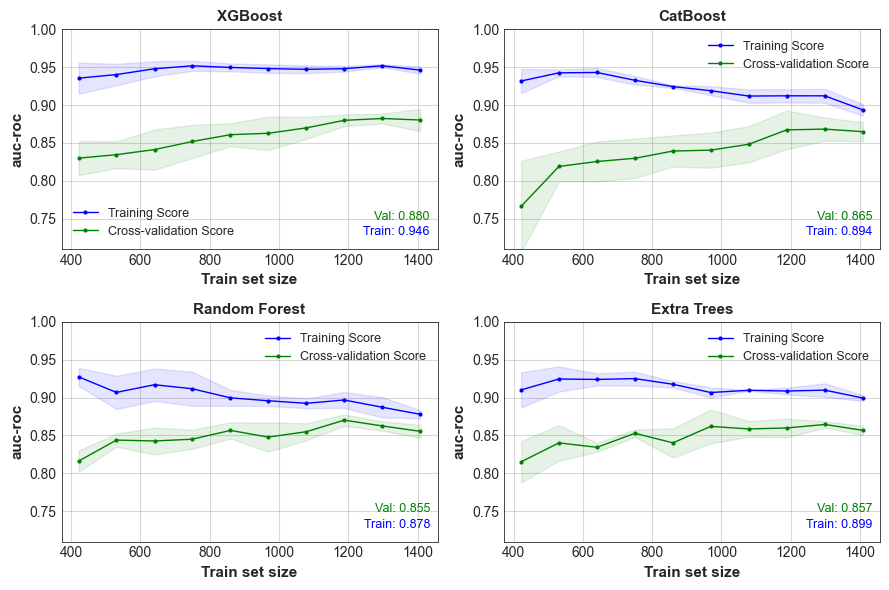

In [27]:
#  learning curves for each algorithm
# Set plot style
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('seaborn-v0_8-darkgrid')

models = [
    ('XGBoost', XGBClassifier(**xgb_best_params)),
    ('CatBoost', CatBoostClassifier(**cb_best_params)),
    ('Random Forest', RandomForestClassifier(**rf_best_params)),
    ('Extra Trees', ExtraTreesClassifier(**et_best_params))
]

def plot_learning_curves(models_, x_, y_, cv_folds=5, train_sizes=np.linspace(0.1, 1.0, 10)):
    fig, axes = plt.subplots(2, 2, figsize=(9, 6))
    axes = axes.flatten()

    for idx, (name, model) in enumerate(models_):
        ax = axes[idx]
        # Calculate learning curve
        train_sizes_abs, train_scores, val_scores = learning_curve(
            estimator=model,
            X=x_,
            y=y_,
            train_sizes=train_sizes,
            cv=StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=43),
            scoring='roc_auc',
            n_jobs=-1,
            verbose=0
        )

        # Calculate mean and standard deviation
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        val_scores_mean = np.mean(val_scores, axis=1)
        val_scores_std = np.std(val_scores, axis=1)

        # Plot learning curve
        ax.plot(train_sizes_abs, train_scores_mean, 'o-', color='blue',
                label='Training Score', linewidth=1, markersize=2)
        ax.plot(train_sizes_abs, val_scores_mean, 'o-', color='green',
                label='Cross-validation Score', linewidth=1, markersize=2)

        # Add standard deviation regions
        ax.fill_between(train_sizes_abs,
                        train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std,
                        alpha=0.1, color='blue')
        ax.fill_between(train_sizes_abs,
                        val_scores_mean - val_scores_std,
                        val_scores_mean + val_scores_std,
                        alpha=0.1, color='green')

        # Set plot properties
        ax.set_xlabel('Train set size', fontsize=11, fontweight='bold')
        ax.set_ylabel('auc-roc', fontsize=11, fontweight='bold')
        ax.set_title(f'{name}', fontsize=11, fontweight='bold')
        ax.legend(loc='best', fontsize=9)

        ax.grid(True, alpha=0.3, color='grey')

         # Set background to white
        ax.set_facecolor('white')
        fig.patch.set_facecolor('white')

        ax.set_ylim([0.71, 1.0])

        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(0.5)

        # Add final accuracy annotations
        final_train = train_scores_mean[-1]
        final_val = val_scores_mean[-1]
        ax.annotate(f'Train: {final_train:.3f}',
                    xy=(0.98, 0.05), xycoords='axes fraction',
                    ha='right', va='bottom', fontsize=9, color='blue')
        ax.annotate(f'Val: {final_val:.3f}',
                    xy=(0.98, 0.12), xycoords='axes fraction',
                    ha='right', va='bottom', fontsize=9, color='green')

    plt.tight_layout()

    # save figure
    save_path = "C:\\Users\\Administrator\Desktop\\notebooks\\learning_curve.png"
    plt.savefig(save_path, dpi=600, bbox_inches='tight')
    print(f"Figure saved to: {save_path}")

    plt.show()

# Plot learning curves
print("\nPlotting learning curves...")
results = plot_learning_curves(
    models_=models,
    x_=X_train,
    y_=y_train,
    cv_folds=3,
    train_sizes=np.linspace(0.3, 1.0, 10)
)

## SHAP

In [22]:
import os

def plot_shap_dot_summary(model, x_, save_path=None, figsize=(2.5, 2.5), plot_size=(2.5, 2.5), fontsize=5):
    # Create SHAP explainer
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_)

    # Determine model type and handle accordingly
    model_type = type(model).__name__
    # Check if model is random forest or extra trees
    if model_type in ['RandomForestClassifier', 'ExtraTreesClassifier']:
        shap_values_list = [shap_values[:, :, i] for i in range(shap_values.shape[2])]
        shap_values = shap_values_list[1]

    # Create figure
    fig, ax = plt.subplots(figsize=figsize)

    # Plot SHAP dot summary
    shap.summary_plot(
        shap_values,
        x_,
        plot_type="dot",
        show=False,
        color_bar=True,
        max_display=25,
        plot_size=plot_size
    )

    # Get feature names
    if hasattr(x_, 'columns'):
        feature_names = x_.columns.tolist()
    else:
        feature_names = [f"Feature_{i}" for i in range(x_.shape[1])]

    # Calculate mean absolute SHAP values for each feature for ranking
    shap_abs_mean = np.abs(shap_values).mean(axis=0)

    # Get indices sorted by importance
    sorted_indices = np.argsort(shap_abs_mean)[::-1]

    # Save top 25 feature names to list
    top_25_features = []
    n_features = min(25, len(feature_names))

    for i in range(n_features):
        idx = sorted_indices[i]
        feature_name = feature_names[idx]
        top_25_features.append(feature_name)

    # Reduce dot sizes by scaling
    for collection in ax.collections:
        # Check if it's a scatter plot (SHAP uses scatter for dots)
        if hasattr(collection, 'get_sizes'):
            sizes = collection.get_sizes()
            if sizes is not None:
                # Reduce dot size to 20% of original
                collection.set_sizes(sizes * 0.2)

    # Modify vertical reference line at x=0.0 - make it thinner
    for line in ax.lines:
        # Check if it's a vertical reference line (x-coordinates are identical and near 0)
        xdata = line.get_xdata()
        if len(xdata) > 0 and all(abs(x - xdata[0]) < 1e-10 for x in xdata) and abs(xdata[0]) < 0.1:
            # Modify line properties
            line.set_linewidth(0.5)  # Set line width
            line.set_color('black')  # Ensure color is black
            line.set_alpha(0.5)  # Set transparency

    # Remove grid lines
    ax.grid(False)

    # Set background to white
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')

    # Custom adjustments
    ax = plt.gca()
    ax.set_xlabel("SHAP Value (Impact on Model Output)", fontsize=fontsize)
    ax.set_ylabel(ax.get_ylabel(), fontsize=fontsize, labelpad=1)

    # Adjust tick labels
    ax.tick_params(axis='y', labelsize=fontsize, pad=-15)
    ax.tick_params(axis='x', labelsize=fontsize, pad=1)

    # Add x-axis tick lines
    ax.spines['bottom'].set_visible(True)
    ax.spines['bottom'].set_color('black')
    ax.spines['bottom'].set_linewidth(0.3)

    # Adjust color bar
    colorbar = ax.figure.axes[-1]  # Color bar is typically the last axis
    colorbar.tick_params(labelsize=5)
    colorbar.set_ylabel('Feature value', fontsize=5, rotation=90, labelpad=1)

    plt.tight_layout()

    # Save or display figure
    if save_path:
        plt.savefig(save_path, dpi=600, bbox_inches='tight', pad_inches=0.05)
        print(f"Figure saved to: {save_path}")
        plt.close()
    plt.show()

    # Return algorithm name and top 25 feature names
    return model_type, top_25_features

def print_feature_frequency(results):
    # Print comparison results
    print("\nAlgorithm Feature Comparison:")
    print("=" * 78)

    # Get all algorithms
    algo_names = list(results.keys())

    # Calculate maximum width for each column (considering algorithm names and feature names)
    col_widths = []
    for algo in algo_names:
        # Calculate maximum width needed for this algorithm column
        max_len = len(algo)
        for feature in results[algo]:
            max_len = max(max_len, len(feature))
        col_widths.append(max_len + 1)  # Add 1 for spacing

    # First row: algorithm names
    for i, algo in enumerate(algo_names):
        print(f"{algo:^{col_widths[i]}}", end="")
    print("\n" + "-" * sum(col_widths))

    # Print features under each algorithm
    for i in range(25):  # Assuming all have 25 features
        for j, algo in enumerate(algo_names):
            features = results[algo]
            if i < len(features):
                print(f"{features[i]:<{col_widths[j]}}", end="")
            else:
                print(f"{'':<{col_widths[j]}}", end="")
        print()
    print("-" * sum(col_widths))

def analyze_feature_frequency(results):
    feature_counts = {}
    feature_algorithms = {}

    # Count feature occurrences and track algorithms
    for algo_name, features in results.items():
        for feature in features:
            if feature in feature_counts:
                feature_counts[feature] += 1
                feature_algorithms[feature].append(algo_name)
            else:
                feature_counts[feature] = 1
                feature_algorithms[feature] = [algo_name]

    # Sort by occurrence count in descending order
    sorted_features = sorted(feature_counts.items(), key=lambda x: x[1], reverse=True)

    # Print results
    print("\nFeature Occurrence Statistics:")
    print("="*120)
    print(f"{'Feature':<30} {'Count':<10} {'Model':<20}")
    print("-"*120)

    for feature, count in sorted_features:
        algo_str = ", ".join(feature_algorithms[feature])
        print(f"{feature:<30} {count:<10} {algo_str:<20}")

    print("-"*120)

results = {}
shap_data = X_train
save_dir = "C:\\Users\\Administrator\Desktop\\notebooks\\figures"

for save_file, model_final in [('xgb_shap_dot_summary.png', xgb_final_model),
                         ('cb_shap_dot_summary.png', cb_final_model),
                         ('rf_shap_dot_summary.png', rf_final_model),
                         ('et_shap_dot_summary.png', et_final_model)]:

    # path
    save_file = os.path.join(save_dir, save_file)

    algo_name, top_features = plot_shap_dot_summary(
            model=model_final,
            x_=shap_data,
            save_path=save_file,
            figsize=(2.5, 3.5),
            plot_size=(2.5, 3.5),
            fontsize=5
            )
    results[algo_name] = top_features

print_feature_frequency(results)

analyze_feature_frequency(results)


Figure saved to: C:\Users\Administrator\Desktop\notebooks\figures\xgb_shap_dot_summary.png
Figure saved to: C:\Users\Administrator\Desktop\notebooks\figures\cb_shap_dot_summary.png
Figure saved to: C:\Users\Administrator\Desktop\notebooks\figures\rf_shap_dot_summary.png
Figure saved to: C:\Users\Administrator\Desktop\notebooks\figures\et_shap_dot_summary.png

Algorithm Feature Comparison:
 XGBClassifier CatBoostClassifier RandomForestClassifier ExtraTreesClassifier 
------------------------------------------------------------------------------
partlyfault    partlyfault        rearend                partlyfault          
moveveh        rearend            partlyfault            rearend              
rearend        unprotected        moveveh                moveveh              
truck          sidewipe           unprotected            truck                
sidewipe       backveh            sidewipe               sidewipe             
dweek1         truck              private              

In [23]:
# interaction
def plot_interaction_only_shap_dot_summary(model, x_, save_path=None, figsize=(2.5, 2.5), plot_size=(2.5, 2.5), fontsize=5):
    # Get interaction values
    shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(x_)

    # Determine model type and handle accordingly
    model_type = type(model).__name__
    if model_type in ['RandomForestClassifier', 'ExtraTreesClassifier']:
        shap_interaction_class = shap_interaction_values[:, :, :, 1]
        shap_interaction_values = shap_interaction_class

    # Calculate importance for each interaction pair (only upper triangle)
    n_features = shap_interaction_values.shape[1]

    if hasattr(X, 'columns'):
        features_ = X.columns.tolist()
    else:
        features_ = [f'Feature_{i}' for i in range(n_features)]

    interaction_data = []

    for i in range(n_features):
        for j in range(i + 1, n_features):  # Only calculate upper triangle
            importance = np.abs(shap_interaction_values[:, i, j]).mean()
            if importance > 0:
                # Calculate total contribution value (i to j and j to i)
                total_importance = importance  # Symmetric, so use directly
                interaction_data.append({
                    'feature1': features_[i],
                    'feature2': features_[j],
                    'feature1_idx': i,
                    'feature2_idx': j,
                    'importance': total_importance
                })

    # Convert to DataFrame and sort
    interaction_df = pd.DataFrame(interaction_data)
    interaction_df = interaction_df.sort_values('importance', ascending=False).head(10)

    # Create a new interaction matrix containing only selected interaction pairs
    shap_interaction_filtered = np.zeros_like(shap_interaction_values)
    feature_indices = set()

    for _, row in interaction_df.iterrows():
        i, j = row['feature1_idx'], row['feature2_idx']
        # Add interaction effects (symmetric)
        shap_interaction_filtered[:, i, j] = shap_interaction_values[:, i, j]
        shap_interaction_filtered[:, j, i] = shap_interaction_values[:, j, i]

        # Record feature indices
        feature_indices.add(i)
        feature_indices.add(j)

    # Create matrix containing only interaction effects (excluding main effects)
    shap_interaction_only = np.zeros_like(shap_interaction_values)
    for _, row in interaction_df.iterrows():
        i, j = row['feature1_idx'], row['feature2_idx']
        shap_interaction_only[:, i, j] = shap_interaction_values[:, i, j]
        shap_interaction_only[:, j, i] = shap_interaction_values[:, j, i]

    # Create figure
    fig, ax = plt.subplots(figsize=figsize)

    # Plot containing only interaction effects
    shap.summary_plot(
        shap_interaction_only,
        x_,
        plot_type="compact_dot",
        max_display=20,  # Each feature may appear multiple times
        show=False,
        color_bar=True,
        plot_size=plot_size
    )

    # Reduce dot sizes by scaling
    for collection in ax.collections:
        # Check if it's a scatter plot (SHAP uses scatter for dots)
        if hasattr(collection, 'get_sizes'):
            sizes = collection.get_sizes()
            if sizes is not None:
                # Reduce dot size to 20% of original
                collection.set_sizes(sizes * 0.2)

    # Modify vertical reference line at x=0.0 - make it thinner
    for line in ax.lines:
        # Check if it's a vertical reference line (x-coordinates are identical and near 0)
        xdata = line.get_xdata()
        if len(xdata) > 0 and all(abs(x - xdata[0]) < 1e-10 for x in xdata) and abs(xdata[0]) < 0.1:
            # Modify line properties
            line.set_linewidth(0.5)  # Set line width
            line.set_color('black')  # Ensure color is black
            line.set_alpha(0.5)  # Set transparency

    # Remove grid lines
    ax.grid(False)

    # Set background to white
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')

    # Custom adjustments
    ax = plt.gca()
    ax.set_xlabel("SHAP Value (Impact on Model Output)", fontsize=fontsize)
    ax.set_ylabel(ax.get_ylabel(), fontsize=fontsize, labelpad=1)

    # Adjust tick labels
    ax.tick_params(axis='y', labelsize=fontsize, pad=-15)
    ax.tick_params(axis='x', labelsize=fontsize, pad=1)

    # Add x-axis tick lines
    ax.spines['bottom'].set_visible(True)
    ax.spines['bottom'].set_color('black')
    ax.spines['bottom'].set_linewidth(0.3)

    # Adjust color bar
    colorbar = ax.figure.axes[-1]  # Color bar is typically the last axis
    colorbar.tick_params(labelsize=5)
    colorbar.set_ylabel('Feature value', fontsize=5, rotation=90, labelpad=1)

    plt.tight_layout()

    # Save or display figure
    if save_path:
        plt.savefig(save_path, dpi=600, bbox_inches='tight', pad_inches=0.05)
        print(f"Figure saved to: {save_path}")
    # plt.show()
    plt.close(fig)

def plot_interaction_only_shap_bar_summary(model, x_, save_path=None, figsize=(3, 3.5), plot_size=(3, 3.5), fontsize=4.5):
    # Get interaction values
    shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(x_)

    # Determine model type and handle accordingly
    model_type = type(model).__name__
    # Check if model is random forest or extra trees
    if model_type in ['RandomForestClassifier', 'ExtraTreesClassifier']:
        shap_interaction_class = shap_interaction_values[:, :, :, 1]
        shap_interaction_values = shap_interaction_class

    # Calculate importance for each interaction pair (only upper triangle)
    n_features = shap_interaction_values.shape[1]

    if hasattr(x_, 'columns'):
        features_ = x_.columns.tolist()
    else:
        # If x_ is not a DataFrame, you need to provide feature name list
        # or use default feature names
        features_ = [f'Feature_{i}' for i in range(n_features)]

    interaction_data = []

    for i in range(n_features):
        for j in range(i + 1, n_features):  # Only calculate upper triangle
            importance = np.abs(shap_interaction_values[:, i, j]).mean()
            if importance > 0:
                # Calculate total contribution value (i to j and j to i)
                total_importance = importance  # Symmetric, so use directly

                # Create unique interaction pair identifier (sorted alphabetically)
                feature_pair = tuple(sorted([features_[i], features_[j]]))
                interaction_data.append({
                    'feature1': feature_pair[0],
                    'feature2': feature_pair[1],
                    'feature1_idx': i,
                    'feature2_idx': j,
                    'importance': total_importance,
                    'pair_label': f"{feature_pair[0]}* - {feature_pair[1]}"  # Add line break for clearer labels
                })

    # Convert to DataFrame and sort
    interaction_df = pd.DataFrame(interaction_data)

    # Sort by importance and get top 10
    interaction_df = interaction_df.sort_values('importance', ascending=False).head(10)

    # Record top ten interaction pairs to variable
    top_interactions = interaction_df[['feature1', 'feature2']].to_dict('records')

    # Create figure
    fig, ax = plt.subplots(figsize=figsize)

    # Plot bar chart
    y_pos = np.arange(len(interaction_df))
    bars = ax.barh(y_pos, interaction_df['importance'].values, align='center')

    ax.set_yticks(y_pos)
    ax.set_yticklabels(interaction_df['pair_label'].values, fontsize=fontsize)
    ax.invert_yaxis()  # Most important at top
    ax.set_xlabel('mean(|SHAP value|)\n(average impact on model output magnitude)', fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize, pad=2)

    # Add x-axis tick marks (short downward vertical lines)
    ax.tick_params(axis='x', which='major', length=2, width=0.3, direction='out', colors='black')

    # Remove grid lines
    ax.grid(False)

    # Set background to white
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')

    # Add y-axis tick lines
    ax.spines['left'].set_visible(True)
    ax.spines['left'].set_color('black')
    ax.spines['left'].set_linewidth(0.3)

    # Add x-axis tick lines
    ax.spines['bottom'].set_visible(True)
    ax.spines['bottom'].set_color('black')
    ax.spines['bottom'].set_linewidth(0.3)

    # Save or display figure
    if save_path:
        plt.savefig(save_path, dpi=600, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")

    # plt.show()
    plt.close()

    return model_type, top_interactions

def print_interaction_frequency(results_interactions):
    # Print results_interactions in table format
    print("\nSummary of Top 10 Interaction Pairs per Algorithm")
    print("=" * 120)

    # Get all algorithm names
    algorithms = list(results_interactions.keys())

    # Calculate maximum number of interaction pairs per algorithm
    max_interactions = max(len(results_interactions[algo]) for algo in algorithms)

    # Print header
    header = "    ".join([f"{algo:<25}" for algo in algorithms])
    print(header)
    print("-" *  120)

    # Print each row (interaction pairs for each rank)
    for i in range(max_interactions):
        row_parts = []
        for algo in algorithms:
            if i < len(results_interactions[algo]):
                interaction = results_interactions[algo][i]
                # Create interaction pair string: feature1*feature2
                pair_str = f"{interaction['feature1']}* -{interaction['feature2']}"
                row_parts.append(f"{pair_str:<25}")
            else:
                row_parts.append(f"{'':<25}")
        print("    ".join(row_parts))

    print("=" * 120)

def analyze_interaction_frequency(results_interactions):
    interaction_counts = {}

    # Create dictionary to store interaction pair details (including algorithms where they appear)
    interaction_details = {}
    # Iterate through each algorithm's results
    for algo_name, interactions in results_interactions.items():
        # Iterate through each interaction pair for this algorithm
        for interaction in interactions:
            # Get the two features of the interaction pair
            feat1 = interaction['feature1']
            feat2 = interaction['feature2']

            # Create standardized interaction pair identifier (sorted alphabetically)
            # Ensure same interaction pair is treated as identical regardless of feature order
            if feat1 < feat2:
                interaction_key = f"{feat1} & {feat2}"
            else:
                interaction_key = f"{feat2} & {feat1}"

            # If interaction pair already in dictionary, increment count and add algorithm name
            if interaction_key in interaction_counts:
                interaction_counts[interaction_key] += 1
                interaction_details[interaction_key]['algorithms'].append(algo_name)
            # Otherwise, initialize count to 1
            else:
                interaction_counts[interaction_key] = 1
                interaction_details[interaction_key] = {
                    'feature1': feat1,
                    'feature2': feat2,
                    'algorithms': [algo_name],
                    'count': 1  # Initial count
                }

    # Update counts in details
    for key in interaction_details:
        interaction_details[key]['count'] = interaction_counts[key]

    # Print result title
    print('\n')
    print("Interaction Pair Occurrence Statistics Across Four Algorithms")

    # Sort by occurrence count in descending order
    sorted_interactions = sorted(interaction_counts.items(), key=lambda x: x[1], reverse=True)

    # Count number of interaction pairs with different occurrence frequencies
    frequency_distribution = {}
    for interaction, count in sorted_interactions:
        if count in frequency_distribution:
            frequency_distribution[count] += 1
        else:
            frequency_distribution[count] = 1

    # Print detailed interaction pair occurrence counts
    print("=" * 130)
    print(f"{'Interaction':<40} {'Count':<10} {'Model':<20}")
    print("-" * 130)

    for interaction, count in sorted_interactions:
        # Get list of algorithms where this interaction pair appears
        algo_list = interaction_details[interaction]['algorithms']
        algo_str = ", ".join(algo_list)
        print(f"{interaction:<40} {count:<10} {algo_str:<20}")
    print("-" * 130)

results_interactions = {}
for save_file, model_final in [('xgb_interaction_shap_bar_summary_only.png', xgb_final_model),
                         ('cb_interaction_shap_bar_summary_only.png', cb_final_model),
                         ('rf_interaction_shap_bar_summary_only.png', rf_final_model),
                         ('et_interaction_shap_bar_summary_only.png', et_final_model)]:

    # complete path
    save_file = os.path.join(save_dir, save_file)
    model_name, top_features =  plot_interaction_only_shap_bar_summary(
            model=model_final,
            x_=shap_data,
            save_path=save_file,
            figsize=(1.5, 2.5),
            fontsize=4.5
        )
    results_interactions[model_name]=top_features

for save_file, model_final in [('xgb_interaction_shap_dot_summary_only.png', xgb_final_model),
                         ('cb_interaction_shap_dot_summary_only.png', cb_final_model),
                         ('rf_interaction_shap_dot_summary_only.png', rf_final_model),
                         ('et_interaction_shap_dot_summary_only.png', et_final_model)]:

    # complete path
    save_file = os.path.join(save_dir, save_file)
    plot_interaction_only_shap_dot_summary(
            model=model_final,
            x_=shap_data,
            save_path=save_file,
            figsize=(3, 3.5),
            plot_size=(3, 3.5),
            fontsize=4.5
        )

print_interaction_frequency(results_interactions)

analyze_interaction_frequency(results_interactions)


Figure saved to: C:\Users\Administrator\Desktop\notebooks\figures\xgb_interaction_shap_bar_summary_only.png
Figure saved to: C:\Users\Administrator\Desktop\notebooks\figures\cb_interaction_shap_bar_summary_only.png
Figure saved to: C:\Users\Administrator\Desktop\notebooks\figures\rf_interaction_shap_bar_summary_only.png
Figure saved to: C:\Users\Administrator\Desktop\notebooks\figures\et_interaction_shap_bar_summary_only.png
Figure saved to: C:\Users\Administrator\Desktop\notebooks\figures\xgb_interaction_shap_dot_summary_only.png
Figure saved to: C:\Users\Administrator\Desktop\notebooks\figures\cb_interaction_shap_dot_summary_only.png
Figure saved to: C:\Users\Administrator\Desktop\notebooks\figures\rf_interaction_shap_dot_summary_only.png
Figure saved to: C:\Users\Administrator\Desktop\notebooks\figures\et_interaction_shap_dot_summary_only.png

Summary of Top 10 Interaction Pairs per Algorithm
XGBClassifier                CatBoostClassifier           RandomForestClassifier       Extr